In [2]:
#https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de

!pip install pydataset
from pydataset import data

df = data('Housing')
df.head()

  Stored in directory: C:\Users\Deggg\AppData\Local\pip\Cache\wheels\fe\3f\dc\5d02ccc767317191b12d042dd920fcf3432fab74bc7978598b
Successfully built pydataset
initiated datasets repo at: C:\Users\Deggg\.pydataset/


,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize, StandardScaler

In [5]:
# Clean up the dataset a bit
d = dict(zip(['no', 'yes'], range(0,2)))

for i in zip(df.dtypes.index, df.dtypes):
    if str(i[1]) == 'object':
        df[i[0]] = df[i[0]].map(d)

# Bucket our prices
df['price'] = pd.qcut(df['price'], 3, labels=['0', '1', '2']).cat.codes

In [6]:
df.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,0,5850,3,1,2,1,0,1,0,0,1,0
2,0,4000,2,1,1,1,0,0,0,0,0,0
3,0,3060,3,1,1,1,0,0,0,0,0,0
4,1,6650,3,1,2,1,1,0,0,0,0,0
5,1,6360,2,1,1,1,0,0,0,0,0,0


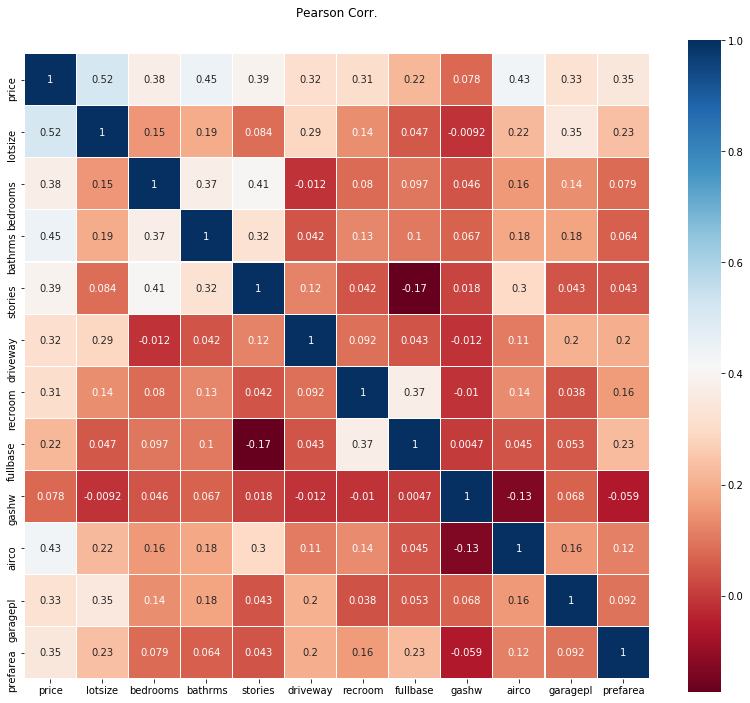

In [7]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Corr.', y=1.05, size=12)
sns.heatmap(df.astype(float).corr(),linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

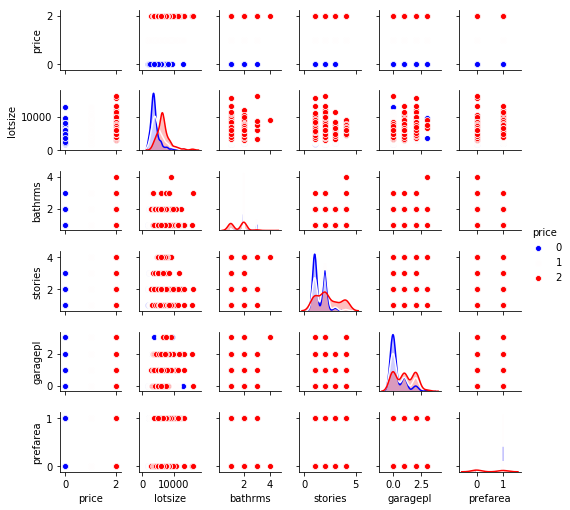

In [9]:
sns.pairplot(df[['price', 'lotsize', 'bathrms', 'stories', 'garagepl', 'prefarea']], 
                 hue='price', palette = 'seismic',height=1.2, diag_kind = 'kde')

In [10]:
# Split up our data
y = df['price'] 
X = df.drop('price', 1)

In [17]:
# Get some classifiers to evaluate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

seed = 1075
np.random.seed(seed)

# Create classifiers
rf = RandomForestClassifier(n_estimators=100)
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC(gamma='auto')
rg = RidgeClassifier()

clf_array = [rf, et, knn, svc, rg]

for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X, y, cv=10, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf, 
       max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10, 
       n_jobs=-1)
    
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__, 
                                                              vanilla_scores.mean(), vanilla_scores.std()))
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__, 
                                                                        bagging_scores.mean(), bagging_scores.std())) 

Mean of: 0.652, std: (+/-) 0.089 [RandomForestClassifier]
Mean of: 0.654, std: (+/-) 0.077 [Bagging RandomForestClassifier]

Mean of: 0.630, std: (+/-) 0.077 [ExtraTreesClassifier]
Mean of: 0.654, std: (+/-) 0.073 [Bagging ExtraTreesClassifier]

Mean of: 0.500, std: (+/-) 0.086 [KNeighborsClassifier]
Mean of: 0.535, std: (+/-) 0.111 [Bagging KNeighborsClassifier]

Mean of: 0.465, std: (+/-) 0.085 [SVC]
Mean of: 0.535, std: (+/-) 0.083 [Bagging SVC]

Mean of: 0.639, std: (+/-) 0.050 [RidgeClassifier]
Mean of: 0.597, std: (+/-) 0.045 [Bagging RidgeClassifier]



In [22]:
# Set up voting
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), 
                                    ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')

for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 
                                                     'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.650, std: (+/-) 0.094 [Random Forest]
Mean: 0.634, std: (+/-) 0.079 [Extra Trees]
Mean: 0.500, std: (+/-) 0.086 [KNeighbors]
Mean: 0.465, std: (+/-) 0.085 [SVC]
Mean: 0.639, std: (+/-) 0.050 [Ridge Classifier]
Mean: 0.636, std: (+/-) 0.089 [Ensemble]


In [23]:
# Set up ensemble voting for bagging
ebclf_array = []

for clf in clf_array:
    ebclf_array.append(BaggingClassifier(clf, max_samples=0.25, 
                                   max_features=10, random_state=seed))

v_eclf = VotingClassifier(estimators=list(zip(['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                                          'Bagging SVC', 'Bagging Ridge Classifier', 'Bagging Ensemble'],
                                         ebclf_array)), 
                          voting='hard')

ebclf_array.append(v_eclf)

for clf, label in zip(ebclf_array, ['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                              'Bagging SVC', 'BaggingRidge Classifier', 'Bagging Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.661, std: (+/-) 0.101 [Bagging Random Forest]
Mean: 0.650, std: (+/-) 0.082 [Bagging Extra Trees]
Mean: 0.535, std: (+/-) 0.117 [Bagging KNeighbors]
Mean: 0.528, std: (+/-) 0.068 [Bagging SVC]
Mean: 0.604, std: (+/-) 0.046 [BaggingRidge Classifier]
Mean: 0.654, std: (+/-) 0.087 [Bagging Ensemble]


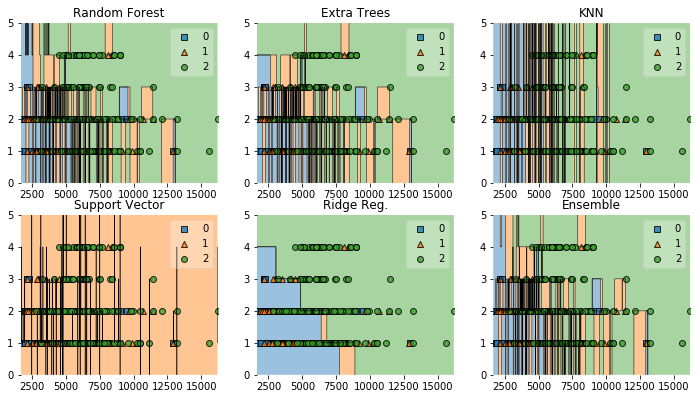

In [25]:
# Now plot the decision regions with only two features
!pip install mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(3, 3)
fig = plt.figure(figsize=(12, 10))
labels = ['Random Forest', 'Extra Trees', 'KNN', 'Support Vector',
          'Ridge Reg.', 'Ensemble']

for clf, lab, grd in zip([rf, et, knn, svc, rg, eclf], 
                         labels,
                         itertools.product([0, 1, 2], repeat = 2)):

    clf.fit(X[['lotsize', 'stories']], y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X[['lotsize', 'stories']]), 
                                y=np.array(y), clf=clf)
    plt.title(lab)

In [27]:
!pip install xgboost

from mlxtend.classifier import EnsembleVoteClassifier
import warnings
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

warnings.filterwarnings('ignore')

# Create boosting classifiers
ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()

boost_array = [ada_boost, grad_boost, xgb_boost]

eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.641, std: (+/-) 0.082 [Ada Boost]
Mean: 0.654, std: (+/-) 0.114 [Grad Boost]
Mean: 0.663, std: (+/-) 0.101 [XG Boost]
Mean: 0.667, std: (+/-) 0.105 [Ensemble]


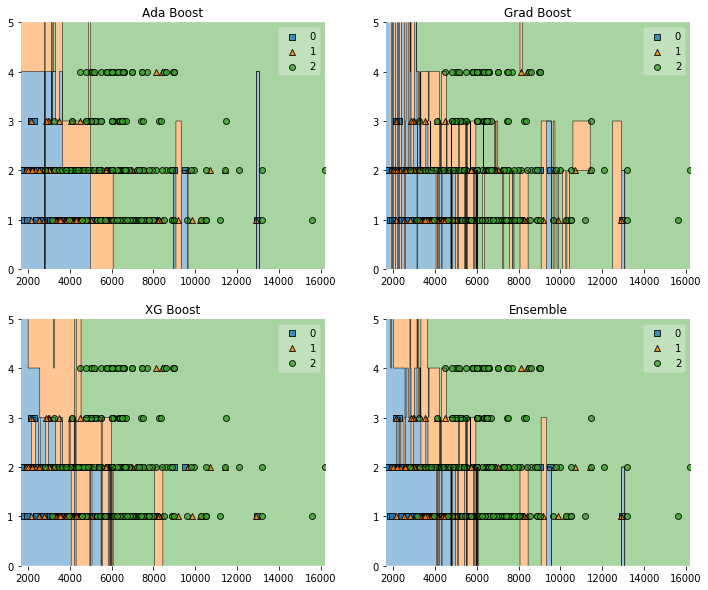

In [28]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(12, 10))

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, lab, grd in zip([ada_boost, grad_boost, xgb_boost, eclf],
                         labels,
                         itertools.product([0, 1], repeat = 2)):

    clf.fit(X[['lotsize', 'stories']].values, y.values)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X[['lotsize', 'stories']].values), 
                                y=np.array(y.values), clf=clf)
    plt.title(lab)

In [31]:
!pip install mlens

from mlens.ensemble import SuperLearner
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

lr = LogisticRegression()

seed = 1075

ensemble = SuperLearner(scorer = accuracy_score, 
                        random_state=seed, 
                        folds=10,
                        verbose = 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

# Build the first layer
ensemble.add([rf, et, knn, rg])
# Attach the final meta estimator
ensemble.add_meta(lr)

ensemble.fit(X_train, y_train)
preds = ensemble.predict(X_test)
print("Fit data:\n%r" % ensemble.data)
print("Accuracy score: {:.3f}".format(accuracy_score(preds, y_test)))


Fitting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:01

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00
Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  extratreesclassifier         0.65     0.09  0.05  0.02  0.01  0.01
layer-1  kneighborsclassifier         0.51     0.07  0.00  0.00  0.03  0.04
layer-1  randomforestclassifier       0.66     0.09  0.27  0.03  0.04  0.02
layer-1  ridgeclassifier              0.65     0.08  0.00  0.00  0.00  0.00

Accuracy score: 0.663


In [34]:
from itertools import combinations

names = ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier']

def zip_stacked_classifiers(*args):
    to_zip = []
    for arg in args:
        combined_items = sum([list(map(list, combinations(arg, i))) for i in range(len(arg) + 1)], [])
        combined_items = filter(lambda x: len(x) > 0, combined_items)
        to_zip.append(combined_items)
    
    return zip(to_zip[0], to_zip[1])

stacked_clf_list = zip_stacked_classifiers(clf_array, names)

best_combination = [0.00, ""]

for clf in stacked_clf_list:
    
    ensemble = SuperLearner(scorer = accuracy_score, 
                            random_state = seed, 
                            folds = 10)
    ensemble.add(clf[0])
    ensemble.add_meta(lr)
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    
    if accuracy > best_combination[0]:
        best_combination[0] = accuracy
        best_combination[1] = clf[1]
    
    print("Accuracy score: {:.3f} {}".format(accuracy, clf[1]))

print("\nBest stacking model is {} with accuracy of: {:.3f}".format(best_combination[1], best_combination[0]))

Accuracy score: 0.663 ['Random Forest']
Accuracy score: 0.652 ['Extra Trees']
Accuracy score: 0.547 ['KNeighbors']
Accuracy score: 0.481 ['SVC']
Accuracy score: 0.635 ['Ridge Classifier']
Accuracy score: 0.652 ['Random Forest', 'Extra Trees']
Accuracy score: 0.635 ['Random Forest', 'KNeighbors']
Accuracy score: 0.646 ['Random Forest', 'SVC']
Accuracy score: 0.663 ['Random Forest', 'Ridge Classifier']
Accuracy score: 0.652 ['Extra Trees', 'KNeighbors']
Accuracy score: 0.635 ['Extra Trees', 'SVC']
Accuracy score: 0.613 ['Extra Trees', 'Ridge Classifier']
Accuracy score: 0.547 ['KNeighbors', 'SVC']
Accuracy score: 0.630 ['KNeighbors', 'Ridge Classifier']
Accuracy score: 0.630 ['SVC', 'Ridge Classifier']
Accuracy score: 0.680 ['Random Forest', 'Extra Trees', 'KNeighbors']
Accuracy score: 0.652 ['Random Forest', 'Extra Trees', 'SVC']
Accuracy score: 0.669 ['Random Forest', 'Extra Trees', 'Ridge Classifier']
Accuracy score: 0.674 ['Random Forest', 'KNeighbors', 'SVC']
Accuracy score: 0.641 [